In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt


In [2]:
df = pd.read_csv('E0.csv')
print(f"Shape of dataset {df.shape}")
df.head()


Shape of dataset (366, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


# Target Variable

As per the goal of the project, we need to predict succesfully if the Away team can win or not.

In [3]:
df['Result'] = (df['FTR'] == 'A').astype(int)

## Converting to Standard Time format

In [4]:
df['Datetime'] = df['Date'] + " " + df['Time']+":00"
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True)
min_date = df['Datetime'].min()
df['Week No.'] = df['Datetime'].apply(lambda x: int((x - min_date).days / 7))

# Generated Features

The goal of the project is to predict the outcome of the game. We are not allowed to use facts about a given match after it has begun, but we can calculate the team's past track record and see how it influences the performance. Here are a list of things we will be calculating - 

1. Current Table Points earned before the start of the game for both the teams. We will use this to calculate Points Difference as a feature in ML Models.

For example, Arsenal has 35 points and Burnley has 23 points at the end of Week 10. In week 11, during their clash, we will use the point difference to predict the results i.e. 12 points. 

2. **Strategy-1**, for calculating both teams' current form. 'Wins' & 'Loses' will be scored normally with +1 & -1 respectively. Teams playing Away should be given an advantage and also teams playing against Elite Teams like {'Man United', 'Chelsea', 'Tottenham', 'Liverpool', 'Man City', 'Arsenal'}. They are both given a +1 and +1 score.

$Current Form 1 = 
\begin{cases}
  +1 & \text{for a win}\\
  +1 & \text{for playing a elite opponent team}\\
  +1 & \text{for playing away}\\
  +0 & \text{for a draw}\\
  -1 & \text{for a defeat}\\
\end{cases}$

3. **Strategy-2**, for calculating both teams' current form. Let's give a form score based on how goals it has scored against a team. But at the same time, extra weightage needs to be given if the win is Away. If the opposing team is very close on the table, that's considered a tougher competition and beating them would mean better form. Here is the logic for this formulation,

      - if Man Utd Lose to Spurs 5-0 at home, it indicates very poor form and great form from Spurs,
      - if Man Utd Defeat Aston 2-0 at home, it indicates decent form for Man Utd as its a home win and average weak form for Aston as its a Away Defeat.

$Goal \; difference = 
\begin{cases}
  +(Home Goal - Away Goal) & \text{for a Home Playing Team}\\
  +1.2(Away Goal - Home Goal) & \text{for a Away Playing Team}\\
\end{cases}$

$Point \; difference = max(0, (Team \; Table \; Point - Opposing \; Team \; Table \; Point))$

$Point \; weightage = \frac{\log(Team \; Table \; Point)}{1 + \log (1 + Point \; difference)}$

$Current \; Form 2 = Goal \; difference * Point \; weightage$

The Reason for Choosing Denominator in Point Weightage -

![log10.jpg](images/log10.png)


In [5]:
def build_ongoing_points_table(df, team_names, elite_teams):
    Teams = df['HomeTeam'].unique().tolist()
    curr_team_points = {team: 0 for team in team_names}
    curr_team_form1 = {team: 1 for team in team_names}
    curr_team_form2 = {team: 1 for team in team_names}
    home_point, away_point = [], []
    home_form1, away_form1 = [], []
    home_form2, away_form2 = [], []
    for index, row in df.iterrows():
        home_point.append(curr_team_points[row['HomeTeam']])
        away_point.append(curr_team_points[row['AwayTeam']])
        home_form1.append(curr_team_form1[row['HomeTeam']])
        away_form1.append(curr_team_form1[row['AwayTeam']])
        home_form2.append(curr_team_form2[row['HomeTeam']])
        away_form2.append(curr_team_form2[row['AwayTeam']])

        home_score1 = 0
        away_score1 = 0.5
        home_score2 = (row['FTHG'] - row['FTAG']) 
        away_score2 = -1.2*home_score2
        away_score2 = max(-1.5, away_score2)
        
        home_point2 = curr_team_points[row['HomeTeam']] 
        away_point2 = curr_team_points[row['AwayTeam']] 
        point_diff_home = home_point2 - away_point2
        point_diff_away = -1 * point_diff_home 
        point_diff_home = max(0.001, point_diff_home)
        point_diff_away = max(0.001, point_diff_away)
        home_score2 *= (math.log(home_point2+3)/(1+math.log(point_diff_home+1, 10)))
        away_score2 *= (math.log(away_point2+3)/(1+math.log(point_diff_away+1, 10)))
        if row['FTR'] == 'H':
            curr_team_points[row['HomeTeam']] += 3
            home_score1 += 1
            away_score1 -= 1
        elif row['FTR'] == 'A':
            curr_team_points[row['AwayTeam']] += 3
            away_score1 += 1
            home_score1 -= 1
        else:
            curr_team_points[row['HomeTeam']] += 1
            curr_team_points[row['AwayTeam']] += 1
        
        if row['HomeTeam'] in elite_teams:
            away_score1 += 0.5
        if row['AwayTeam'] in elite_teams:
            home_score1 += 0.5
        
        curr_team_form1[row['HomeTeam']] *= 0.75
        curr_team_form1[row['HomeTeam']] += home_score1
        curr_team_form1[row['AwayTeam']] *= 0.75
        curr_team_form1[row['AwayTeam']] += away_score1

        curr_team_form2[row['HomeTeam']] *= 0.75
        curr_team_form2[row['HomeTeam']] += home_score2
        curr_team_form2[row['AwayTeam']] *= 0.75
        curr_team_form2[row['AwayTeam']] += away_score2
    
    df['HomePoint'] = home_point
    df['AwayPoint'] = away_point
    df['HomeForm1'] = home_form1
    df['AwayForm1'] = away_form1
    df['HomeForm2'] = home_form2
    df['AwayForm2'] = away_form2
    return df

def find_optimal_threshold(df, feature_name):
    mint, maxt = df[feature_name].min(), df[feature_name].max()
    thres = np.linspace(int(mint), int(maxt), num=int(maxt) - int(mint)+1)
    max_score = 0
    max_t = None
    for t in thres:
        score_t = ((df[feature_name] > t).astype(int) == df['Result']).mean()
        if score_t > max_score:
            max_score = score_t
            max_t = t
    
    print(f"For {feature_name} at threshold {max_t}, we get accuracy {max_score}")
    return max_score, max_t


## Performance of our custom Formula and Baseline

Lets extract, ongoing Points Table score & Custom team form value.
Using this, we will also calculate the difference Points as `Point Diff` and Form difference as `Form Diff 1` & `Form Diff 2`.

Lets use point difference, form difference as measure of building the baseline model. 

1. If $Away Team Table Points - Home Team Table Points > Threshold$, then 1 else 0
2. If $Away Team Form score 1 - Home Team Form score 1 > Threshold$, then 1 else 0
2. If $Away Team Form score 2 - Home Team Form score 2 > Threshold$, then 1 else 0

We will be using the `find_optimal_threshold` function to determine the threshold

In [6]:
elite_teams = [
    'Man United', 'Chelsea', 'Tottenham', 'Liverpool', 'Man City', 'Arsenal'
]
Teams = df['HomeTeam'].unique().tolist()
df = build_ongoing_points_table(df, Teams, elite_teams)
df['Point Diff'] = df['AwayPoint'] - df['HomePoint']
df['Form Diff 1'] = df['AwayForm1'] - df['HomeForm1']
df['Form Diff 2'] = df['AwayForm2'] - df['HomeForm2']


### Baseline using Point Difference

In [7]:
point_diff_acc, point_diff_thres = find_optimal_threshold(df, 'Point Diff')


For Point Diff at threshold 14.0, we get accuracy 0.7049180327868853


### Baseline using Form Difference 1

In [8]:
form_diff_acc1, form_diff_thres1 = find_optimal_threshold(df, 'Form Diff 1')


For Form Diff 1 at threshold 2.0, we get accuracy 0.6967213114754098


### Baseline using Form Difference 2

In [9]:
form_diff_acc2, form_diff_thres2 = find_optimal_threshold(df, 'Form Diff 2')

For Form Diff 2 at threshold 9.0, we get accuracy 0.7049180327868853


In [10]:
elite_teams = [
    'Man United', 'Chelsea', 'Tottenham', 'Liverpool', 'Man City', 'Arsenal'
]
Teams = df['HomeTeam'].unique().tolist()
df = build_ongoing_points_table(df, Teams, elite_teams)
df['predict1'] = (df['AwayForm1'] > df['HomeForm1']).astype(int)
df['predict2'] = (df['AwayForm2'] > df['HomeForm2']).astype(int)
df['match1'] = (df['predict1'] == df['Result']).astype(int)
df['match2'] = (df['predict2'] == df['Result']).astype(int)
df['diff1'] = df['AwayForm1'] - df['HomeForm1']
df['diff2'] = df['AwayForm2'] - df['HomeForm2']

Correct_df = df[df['match2'] == 1]
Error_df = df[df['match2'] == 0]

print(f"Accuracy from stratergy1 {(df['match1']).mean()}")
print(f"Accuracy from stratergy2 {(df['match2']).mean()}")

Accuracy from stratergy1 0.6010928961748634
Accuracy from stratergy2 0.6229508196721312


---

Let us find out occurrences where our custom form failed to give a good score. `Correct_df` is a Dataframe consisting of all the correctly classified instances. `Error_df` is Dataframe consisting of all the incorrectly classified instances.


In [11]:
df['predict point'] = (df['Point Diff'] > point_diff_thres).astype(int)
df['predict form1'] = (df['Form Diff 1'] > form_diff_thres1).astype(int)
df['predict form2'] = (df['Form Diff 2'] > form_diff_thres2).astype(int)


df['match from points'] = (df['predict point'] == df['Result']).astype(int)
df['match from form1'] = (df['predict form1'] == df['Result']).astype(int)
df['match from form2'] = (df['predict form2'] == df['Result']).astype(int)

# Correct_df = df[df['match2'] == 1]
# Error_df = df[df['match2'] == 0]


### Error Analysis from Point Difference

0    89
1    19
Name: predict point, dtype: int64


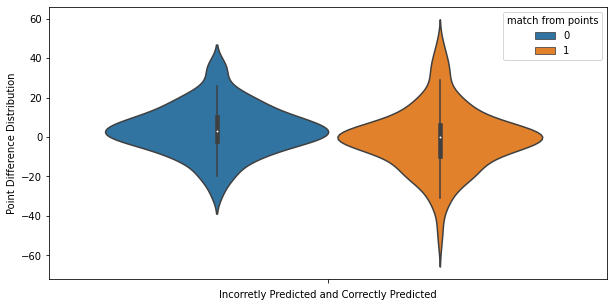

In [12]:
Error_df = df[df['match from points'] == 0]
print(Error_df['predict point'].value_counts())
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Point Diff", hue="match from points", data=df)
ax.set_ylabel("Point Difference Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

### Error Analysis from Form Difference 1

0    87
1    24
Name: predict form1, dtype: int64


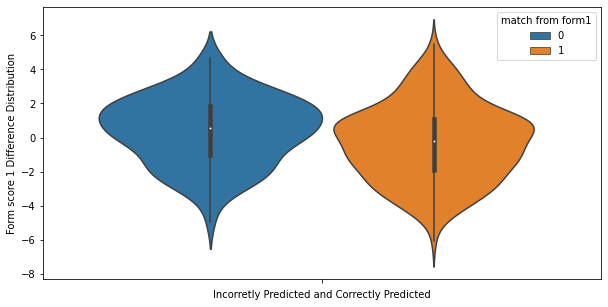

In [13]:
Error_df = df[df['match from form1'] == 0]
print(Error_df['predict form1'].value_counts())
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Form Diff 1", hue="match from form1", data=df)
ax.set_ylabel("Form score 1 Difference Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

### Error Analysis from Form Difference 2

0    81
1    27
Name: predict form2, dtype: int64


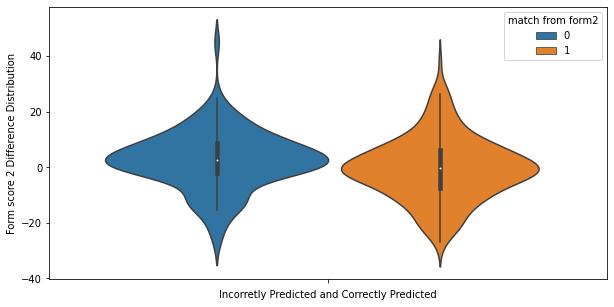

In [14]:
Error_df = df[df['match from form2'] == 0]
print(Error_df['predict form2'].value_counts())
df["all"] = ""
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="all", y="Form Diff 2", hue="match from form2", data=df)
ax.set_ylabel("Form score 2 Difference Distribution")
ax.set_xlabel("Incorretly Predicted and Correctly Predicted")
plt.show()

In [15]:
Correct_df['HomeTeam'].value_counts()

Watford           18
Liverpool         16
Man City          15
Arsenal           14
Brentford         12
Wolves            12
Brighton          12
Tottenham         12
Chelsea           11
Norwich           11
Crystal Palace    11
Man United        10
Everton           10
Leeds             10
Aston Villa        9
Leicester          9
West Ham           9
Newcastle          9
Burnley            9
Southampton        9
Name: HomeTeam, dtype: int64

In [16]:
Error_df['AwayTeam'].value_counts()

Chelsea           10
Arsenal            8
Aston Villa        8
Man United         7
Brighton           7
West Ham           7
Everton            6
Wolves             6
Liverpool          6
Man City           6
Tottenham          5
Brentford          5
Watford            5
Crystal Palace     5
Leeds              4
Leicester          3
Southampton        3
Newcastle          3
Norwich            2
Burnley            2
Name: AwayTeam, dtype: int64

---

We have also plotted the accuracy of the model as progress through the weeks in the season,

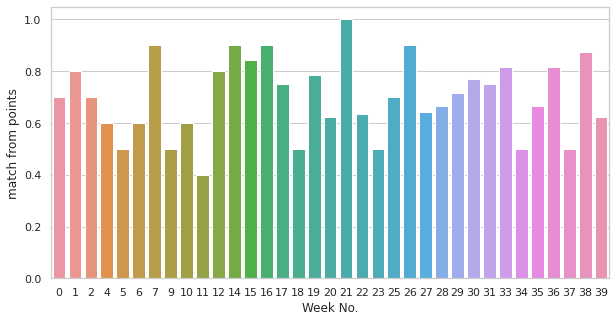

In [17]:
week_results = df.groupby(['Week No.'])['match from points'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Week No.", y='match from points',data=week_results)
plt.show()

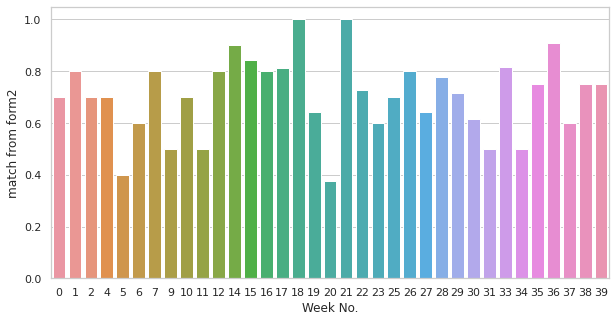

In [18]:
week_results = df.groupby(['Week No.'])['match from form2'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Week No.", y='match from form2',data=week_results)
plt.show()

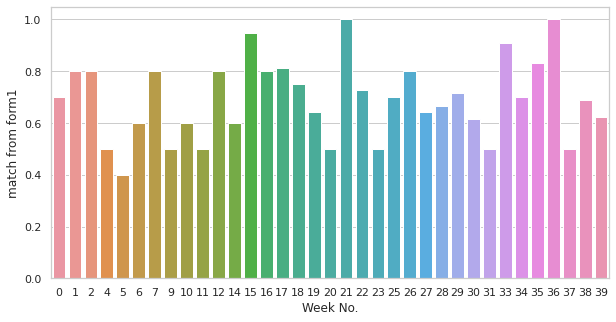

In [19]:
week_results = df.groupby(['Week No.'])['match from form1'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Week No.", y='match from form1',data=week_results)
plt.show()